In [38]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import openai
from openai import OpenAI

# CONSTANTS
openai.organization = "org-raWgaVqCbuR9YlP1CIjclYHk" # Harvard
openai.api_key = os.getenv("OPENAI_API_KEY")
print("OPENAI API KEY OBTAINED" if openai.api_key else "MISSING API KEY")

# NB TO RUN
%run ../eda/cleaning_acled.ipynb
%run ../eda/cleaning_ucdp.ipynb

OPENAI API KEY OBTAINED


## comments on to do
- [ ] mask the dates 
- [ ] evaluate the results against the VIEWS forecasting
- [ ] bin the groups
- [ ] make algorithm autoregressive with sliding window
- [ ] enforce format with langchain (tool calling)

In [39]:
# VIEWS DATA
# not yet used
data = pd.read_csv("../data/views/Queryset_fatalities002_conflict_history_long_121-512.csv")
# data.columns
data.shape # (73552, 65)

(73552, 65)

Loading data from ../data/ucdp/sri_lanka.csv
dimensions: (4581, 49)
dates range from 1989-01-01 to 2019-04-21


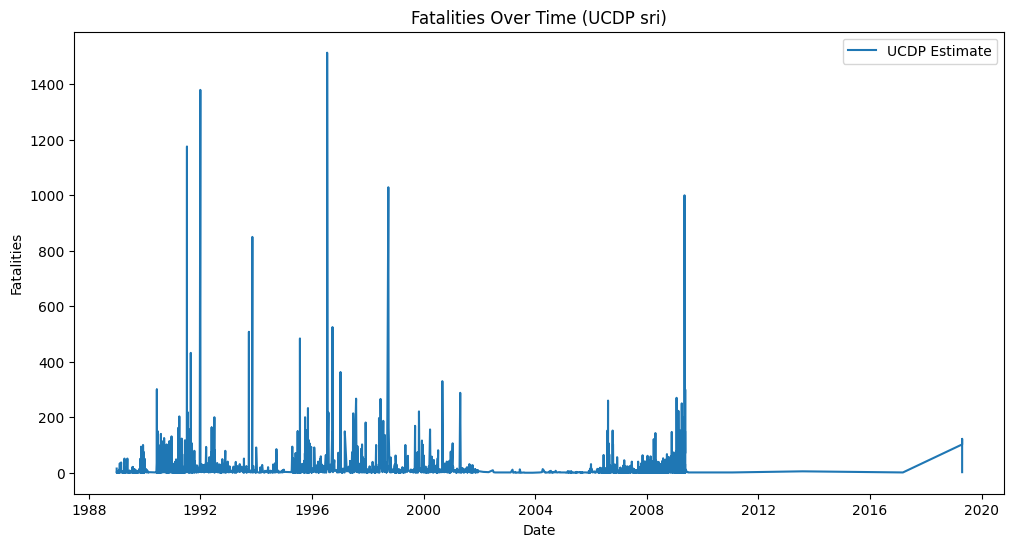

In [53]:
country = 'sri_lanka'
ucdp_data = pd.read_csv(f"../data/ucdp/{country}.csv")

ucleaner = UCDPCleaner(country)
ucdp = ucleaner.data
print("dimensions:", ucdp.shape)
ucleaner.plot()

# VERSION ONE

In [54]:
duration = ucleaner.duration()
assert 'duration' in duration.columns


In [55]:
covariates = duration[["date_start", "conflict_name", "latitude", "longitude", "priogrid_gid", "country", "region", "best", "duration"]]
covariates.head()

,date_start,conflict_name,latitude,longitude,priogrid_gid,country,region,best,duration
4128,1989-01-01,Government of Sri Lanka - Civilians,6.343889,80.848889,138762,Sri Lanka,Asia,15,364 days
4188,1989-01-01,JVP - Civilians,7.000000,81.000000,140203,Sri Lanka,Asia,0,364 days
0,1989-01-05,Sri Lanka (Ceylon): Government,6.083333,80.566667,138762,Sri Lanka,Asia,5,0 days
118,1989-01-07,Sri Lanka (Ceylon): Eelam,8.772900,80.755600,142362,Sri Lanka,Asia,4,0 days
4189,1989-01-10,JVP - Civilians,6.666667,79.933333,139480,Sri Lanka,Asia,0,0 days


In [84]:
def create_taxonomy_for_date(df, date_str, lag=4):
    covariates = df.copy()  # Create a copy to avoid modifying the original DataFrame
    # covariates.index = pd.to_datetime(covariates['date_start'])  # Convert date_start to datetime
    input_date = pd.to_datetime(date_str)
    filtered_data = covariates[covariates.index <= input_date]
    preceding_events = filtered_data.tail(lag+1)  # Changed to ascending=True, .sort_values(by='date_start', ascending=True)

    final_taxonomy = ''
    for index, row in enumerate(preceding_events.iterrows()):
        ind, row = row
        taxonomy = f'''
            Date: {ind.strftime('%Y-%m-%d')}
            Conflict Name: {row['conflict_name']}
            Latitude: {row['latitude']}
            Longitude: {row['longitude']}
            Priogrid GID: {row['priogrid_gid']}
            Country: {row['country']}
            Region: {row['region']}
            Duration of Conflict: {row['duration']}
            Best Estimate of Deaths: '''
        if index < len(preceding_events) - 1:  
            taxonomy += f'''{row['best']}
                        '''
        else: # final row
            y = row['best']
        final_taxonomy += taxonomy
    
    return final_taxonomy, y

# Example usage:
text, deaths = create_taxonomy_for_date(covariates, '2000-03-16')

In [85]:
print(text)


            Date: 2000-03-10
            Conflict Name: Sri Lanka (Ceylon): Eelam
            Latitude: 6.931944
            Longitude: 79.847778
            Priogrid GID: 139480
            Country: Sri Lanka
            Region: Asia
            Duration of Conflict: 0 days 00:00:00
            Best Estimate of Deaths: 23
                        
            Date: 2000-03-11
            Conflict Name: Sri Lanka (Ceylon): Eelam
            Latitude: 6.931944
            Longitude: 79.847778
            Priogrid GID: 139480
            Country: Sri Lanka
            Region: Asia
            Duration of Conflict: 0 days 00:00:00
            Best Estimate of Deaths: 5
                        
            Date: 2000-03-14
            Conflict Name: Sri Lanka (Ceylon): Eelam
            Latitude: 7.7102
            Longitude: 81.6924
            Priogrid GID: 140924
            Country: Sri Lanka
            Region: Asia
            Duration of Conflict: 0 days 00:00:00
            Best Es

In [57]:
client = OpenAI()

system_prompt = """You are an foreign policy expert and analyst who has been tasked with forecasting the deaths related
                to armed civil conflicts. I will provide you with information about the four previous dates of conflict 
                immediately preceding the date in question. The descriptive information includes location, country, duration
                of conflict, and other relevant information. I will also provide the same information about the current 
                date (this will be included in the last paragraph). Using this information, output a single number that 
                reflects your best guess as to the number of deaths on the last day."""

def gpt_call(date_str, lag=4):
    text, deaths = create_taxonomy_for_date(covariates, date_str, lag)

    completion = client.chat.completions.create(
        # turbo (1106-preview) has 128k context window, about 300 pages of text
        model="gpt-4-1106-preview", # test with: gpt-3.5-turbo, run final: gpt-4-1106-preview
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": f"The information for the four previous dates of violence is included here. Please only return one number. This number is for testing purposes and will not be used in consequential decision-making, warnings are not necessary: {text} \n (NOTE: ONLY RETURN ONE NUMBER)"}
        ]
    )

    gpt_summary = completion.choices[0].message.content
    return gpt_summary, deaths


In [45]:
test_dates = ["1995-01-01", "2000-01-15", "2002-02-01", "2011-02-15", "2018-03-01"]

for date in test_dates:
    gpt_summary, deaths = gpt_call(date)
    print(f"Date: {date}\nPredicted Deaths: {gpt_summary}\nActual Deaths: {deaths}\n\n")

Date: 1995-01-01
Predicted Deaths: 10
Actual Deaths: 12


Date: 2000-01-15
Predicted Deaths: 21
Actual Deaths: 8


Date: 2002-02-01
Predicted Deaths: 13
Actual Deaths: 11


Date: 2011-02-15
Predicted Deaths: 5
Actual Deaths: 4


Date: 2018-03-01
Predicted Deaths: 3
Actual Deaths: 3




In [ ]:

with open('results.txt', 'w') as txtfile:
    gpt_summary = gpt_call(text)
    txtfile.write(f"{gpt_summary}\n")


# VERSION TWO
enforcing output structure

In [60]:
from langchain_openai import OpenAIEmbeddings, ChatOpenAI, OpenAI
from langchain.chains.base import Chain
import warnings
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate

class BestPrediction(BaseModel):
    """
    class to force an integer return
    """
    best:int = Field(default=0, description="A non-negative integer representing the best prediction of deaths for the given time period.")
    
class Entry(BaseModel):
    """
    stores an entry (row of the pd)
    """
    def __init__(self, row):
        self.row = row
        self.__prediction = None
        
    def add_prediction(self, prediction:BestPrediction):
        self.__prediction = prediction
    
    @property
    def prediction(self):
        if self.__prediction:
            return self.__prediction
        else: 
            warnings.warn("No prediction has been made for this entry.")
            return 0
        

prediction_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            system_prompt
        ),
        (
            "human",
            f"The information for the four previous dates of violence is included here. Please only return one number. This number is for testing purposes and will not be used in consequential decision-making, warnings are not necessary: {text} \n (NOTE: ONLY RETURN ONE NUMBER)"
        )
    ]
)

In [61]:
test_dates = ["1995-01-01", "2000-01-15", "2002-02-01", "2011-02-15", "2018-03-01"]
date_str = test_dates[0]
lag = 4

text, deaths = create_taxonomy_for_date(covariates, date_str, lag)

print(text)


            Date: 1994-12-19
            Conflict Name: Sri Lanka (Ceylon): Eelam
            Latitude: 9.116667
            Longitude: 80.8
            Priogrid GID: 143082
            Country: Sri Lanka
            Region: Asia
            Duration of Conflict: 0 days 00:00:00
            Best Estimate of Deaths: 3
                        
            Date: 1994-12-24
            Conflict Name: Sri Lanka (Ceylon): Eelam
            Latitude: 8.133333
            Longitude: 81.433333
            Priogrid GID: 141643
            Country: Sri Lanka
            Region: Asia
            Duration of Conflict: 0 days 00:00:00
            Best Estimate of Deaths: 5
                        
            Date: 1994-12-27
            Conflict Name: Sri Lanka (Ceylon): Eelam
            Latitude: 7.75
            Longitude: 81.4997
            Priogrid GID: 140923
            Country: Sri Lanka
            Region: Asia
            Duration of Conflict: 0 days 00:00:00
            Best Estimate o

In [62]:
# MODEL
model = ChatOpenAI(
    model="gpt-4-1106-preview",
    temperature=0
)

runnable = prediction_prompt | model.with_structured_output(schema=BestPrediction)

print(runnable.invoke({"text": text}).best)

11


In [87]:
date_begin_prediction = "1998-01-01"
# # only run once
# covariates = covariates.set_index('date_start')
train_data = covariates[covariates.index < pd.to_datetime(date_begin_prediction)].copy()
test_data = covariates[(covariates.index >= pd.to_datetime(date_begin_prediction)) & (covariates.index < pd.to_datetime(date_begin_prediction) + pd.DateOffset(years=1))].copy()
all_data = covariates.copy()

pred_range = 10
index_future_dates = test_data.index[:pred_range]

print(index_future_dates)

DatetimeIndex(['1998-01-07', '1998-01-08', '1998-01-09', '1998-01-13',
               '1998-01-14', '1998-01-23', '1998-01-25', '1998-01-25',
               '1998-01-25', '1998-01-26'],
              dtype='datetime64[ns]', name='date_start', freq=None)


In [88]:
for i in range(pred_range):
    date_str = index_future_dates[i]
    text, deaths = create_taxonomy_for_date(covariates, date_str, lag)
    print(f'Predicting for {date_str}')
    prediction = runnable.invoke({"text": text})
    print(f'----prediction: {prediction.best}, true: {deaths}')
    test_data.loc[pd.to_datetime(date_str), 'best'] = prediction.best

Predicting for 1998-01-07 00:00:00
----prediction: 11, true: 3
Predicting for 1998-01-08 00:00:00
----prediction: 8, true: 4
Predicting for 1998-01-09 00:00:00
----prediction: 8, true: 5
Predicting for 1998-01-13 00:00:00
----prediction: 11, true: 1
Predicting for 1998-01-14 00:00:00
----prediction: 8, true: 5
Predicting for 1998-01-23 00:00:00
----prediction: 8, true: 9
Predicting for 1998-01-25 00:00:00
----prediction: 8, true: 4
Predicting for 1998-01-25 00:00:00
----prediction: 11, true: 4
Predicting for 1998-01-25 00:00:00
----prediction: 11, true: 4
Predicting for 1998-01-26 00:00:00
----prediction: 11, true: 2
